In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [28]:
df=pd.read_csv("master_dataset.csv",low_memory=False)

In [29]:
current_columns = df.columns.tolist()
new_columns = current_columns[1:] + ['empty_column']
df_fixed = df.copy()
df_fixed.columns = new_columns
df = df_fixed.drop('empty_column', axis=1)

In [30]:
df.columns

Index(['region', 'country', 'ip_latitude', 'ip_longitude', 'ip_accuracy',
       'sex', 'age', 'height', 'weight', 'bmi', 'blood_type', 'insurance',
       'income', 'race', 'immigrant', 'smoking', 'alcohol', 'cannabis',
       'amphetamines', 'cocaine', 'lsd', 'mdma', 'contacts_count',
       'house_count', 'public_transport_count', 'working', 'worried',
       'rate_reducing_risk_single',
       'rate_reducing_risk_single_social_distancing',
       'rate_reducing_risk_single_washing_hands', 'rate_reducing_risk_house',
       'rate_reducing_risk_house_social_distancing',
       'rate_reducing_risk_house_washing_hands',
       'rate_reducing_risk_single_sanitizer', 'rate_reducing_mask',
       'rate_reducing_mask_type', 'rate_government_action',
       'rate_government_control', 'rate_government_spend', 'covid19_positive',
       'covid19_symptoms', 'covid19_contact', 'asthma', 'kidney_disease',
       'liver_disease', 'compromised_immune', 'heart_disease', 'lung_disease',
       'diab

In [31]:
df = df[['sex', 'age', 'bmi','smoking','alcohol','cannabis','amphetamines','cocaine','contacts_count','working','rate_reducing_risk_single','rate_reducing_mask','covid19_symptoms','covid19_contact','asthma','kidney_disease','liver_disease','compromised_immune','heart_disease','lung_disease','diabetes','hiv_positive','hypertension','other_chronic','nursing_home','health_worker','covid19_positive']]


In [32]:
 df.isnull().sum()

sex                               0
age                               5
bmi                               4
smoking                        1857
alcohol                        1897
cannabis                     286811
amphetamines                 307237
cocaine                      309438
contacts_count                 4247
working                        4236
rate_reducing_risk_single         0
rate_reducing_mask             1857
covid19_symptoms                  0
covid19_contact                   0
asthma                            0
kidney_disease                    0
liver_disease                     0
compromised_immune                0
heart_disease                     0
lung_disease                      0
diabetes                          0
hiv_positive                      0
hypertension                      0
other_chronic                     0
nursing_home                      0
health_worker                     0
covid19_positive                  0
dtype: int64

In [33]:
df.nunique()

sex                            4
age                           11
bmi                          752
smoking                        8
alcohol                       16
cannabis                      31
amphetamines                  31
cocaine                       31
contacts_count                22
working                        5
rate_reducing_risk_single      5
rate_reducing_mask             5
covid19_symptoms               2
covid19_contact                2
asthma                         2
kidney_disease                 2
liver_disease                  2
compromised_immune             2
heart_disease                  2
lung_disease                   2
diabetes                       2
hiv_positive                   2
hypertension                   2
other_chronic                  2
nursing_home                   2
health_worker                  2
covid19_positive               2
dtype: int64

In [34]:
# Exclude 'health worker' column
unique_entries = {
    col: df[col].dropna().unique().tolist()
    for col in df.columns
}

# Display results
print("Unique entries in each column (excluding 'health worker'):")
for col, values in unique_entries.items():
    print(f"{col}: {values}")


Unique entries in each column (excluding 'health worker'):
sex: ['male', 'female', 'other', 'undefined']
age: ['20_30', '30_40', '90_100', '60_70', '40_50', '80_90', '50_60', '70_80', '10_20', '0_10', '100_110']
bmi: [27.7, 21.6, 32.4, 25.4, 29.7, 23.1, 23.7, 32.6, 27.1, 35.1, 22.9, 34.6, 24.4, 26.4, 38.0, 24.9, 33.3, 22.1, 29.5, 23.6, 36.8, 22.4, 30.9, 24.1, 28.9, 25.8, 22.0, 21.7, 35.0, 47.4, 32.2, 30.4, 20.6, 18.4, 34.0, 20.5, 19.3, 24.3, 21.2, 41.6, 31.5, 42.1, 26.5, 19.9, 32.7, 23.3, 25.7, 19.4, 22.8, 40.9, 36.9, 34.8, 23.5, 26.2, 16.5, 28.7, 28.2, 23.0, 31.6, 23.2, 33.8, 33.6, 23.9, 45.3, 31.2, 28.4, 24.8, 21.4, 48.4, 28.1, 26.6, 52.9, 25.1, 38.8, 20.8, 36.2, 38.4, 26.9, 25.3, 47.6, 35.2, 35.8, 18.3, 27.6, 18.5, 20.0, 38.9, 44.6, 24.6, 31.3, 42.8, 20.1, 21.5, 22.2, 18.9, 21.9, 27.9, 17.3, 19.8, 37.1, 29.6, 19.7, 16.7, 30.0, 34.2, 40.6, 46.0, 27.5, 33.4, 23.8, 28.3, 32.0, 31.7, 18.7, 27.0, 33.1, 29.0, 40.2, 21.0, 30.1, 31.0, 20.9, 36.5, 51.7, 19.0, 19.1, 22.3, 33.7, 31.9, 26.7, 41

In [35]:

def process_age_column(df, age_column='age'):
    """
    Process age column containing string ranges like '20_30' to their average values
    and handle null values by replacing them with mean.
    
    Parameters:
    df: pandas DataFrame
    age_column: str, name of the age column (default='age')
    
    Returns:
    pandas Series with processed age values
    """
    def extract_average(age_str):
        if pd.isna(age_str):
            return np.nan
        try:
            # Split the string on '_' and convert to integers
            start, end = map(int, str(age_str).split('_'))
            return (start + end) / 2
        except:
            return np.nan
    
    # Convert string ranges to averages
    processed_ages = df[age_column].apply(extract_average)
    
    # Replace null values with mean
    mean_age = processed_ages.mean()
    processed_ages = processed_ages.fillna(mean_age)
    
    return processed_ages

df['age'] = process_age_column(df, age_column='age')

In [36]:
categorical_cols = ['sex', 'age', 'smoking', 'alcohol', 'working', 'cannabis', 
                       'amphetamines', 'cocaine']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

In [37]:
numerical_cols = ['bmi', 'contacts_count', 'rate_reducing_mask']
for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

In [38]:
nominal_cols = ['sex', 'smoking', 'working']
df_encoded = pd.get_dummies(df, columns=nominal_cols)
drug_cols = ['cannabis', 'amphetamines', 'cocaine']
for col in drug_cols:
    if col in df_encoded.columns:
        df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')
df=df_encoded

In [41]:
from sklearn.preprocessing import MinMaxScaler
!pip install imblearn
from imblearn.over_sampling import SMOTE

scaler = MinMaxScaler()
cols_to_normalize = [col for col in df.columns if col != 'covid19_positive']
df_normalized = df.copy()
df_normalized[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
df=df_normalized

In [42]:
X = df.drop('covid19_positive', axis=1)
y = df['covid19_positive']
    
    # Calculate sampling strategy for 1:3 ratio
ratio = 1/3  # Desired ratio of minority to majority class
n_majority = sum(y == 0)
sampling_strategy = int(n_majority * ratio)
    
# Apply SMOTE
smote = SMOTE(sampling_strategy={1: sampling_strategy}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
    
# Combine features and target back into DataFrame
df_balanced = pd.concat([pd.DataFrame(X_balanced, columns=X.columns),
                           pd.Series(y_balanced, name='covid19_positive')], axis=1)
    
df=df_balanced

In [43]:
len(df)

1348342


==== Basic Information ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348342 entries, 0 to 1348341
Data columns (total 41 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   age                          1348342 non-null  float64
 1   bmi                          1348342 non-null  float64
 2   alcohol                      1348342 non-null  float64
 3   cannabis                     1348342 non-null  float64
 4   amphetamines                 1348342 non-null  float64
 5   cocaine                      1348342 non-null  float64
 6   contacts_count               1348342 non-null  float64
 7   rate_reducing_risk_single    1348342 non-null  float64
 8   rate_reducing_mask           1348342 non-null  float64
 9   covid19_symptoms             1348342 non-null  float64
 10  covid19_contact              1348342 non-null  float64
 11  asthma                       1348342 non-null  float64
 12  kidney_diseas

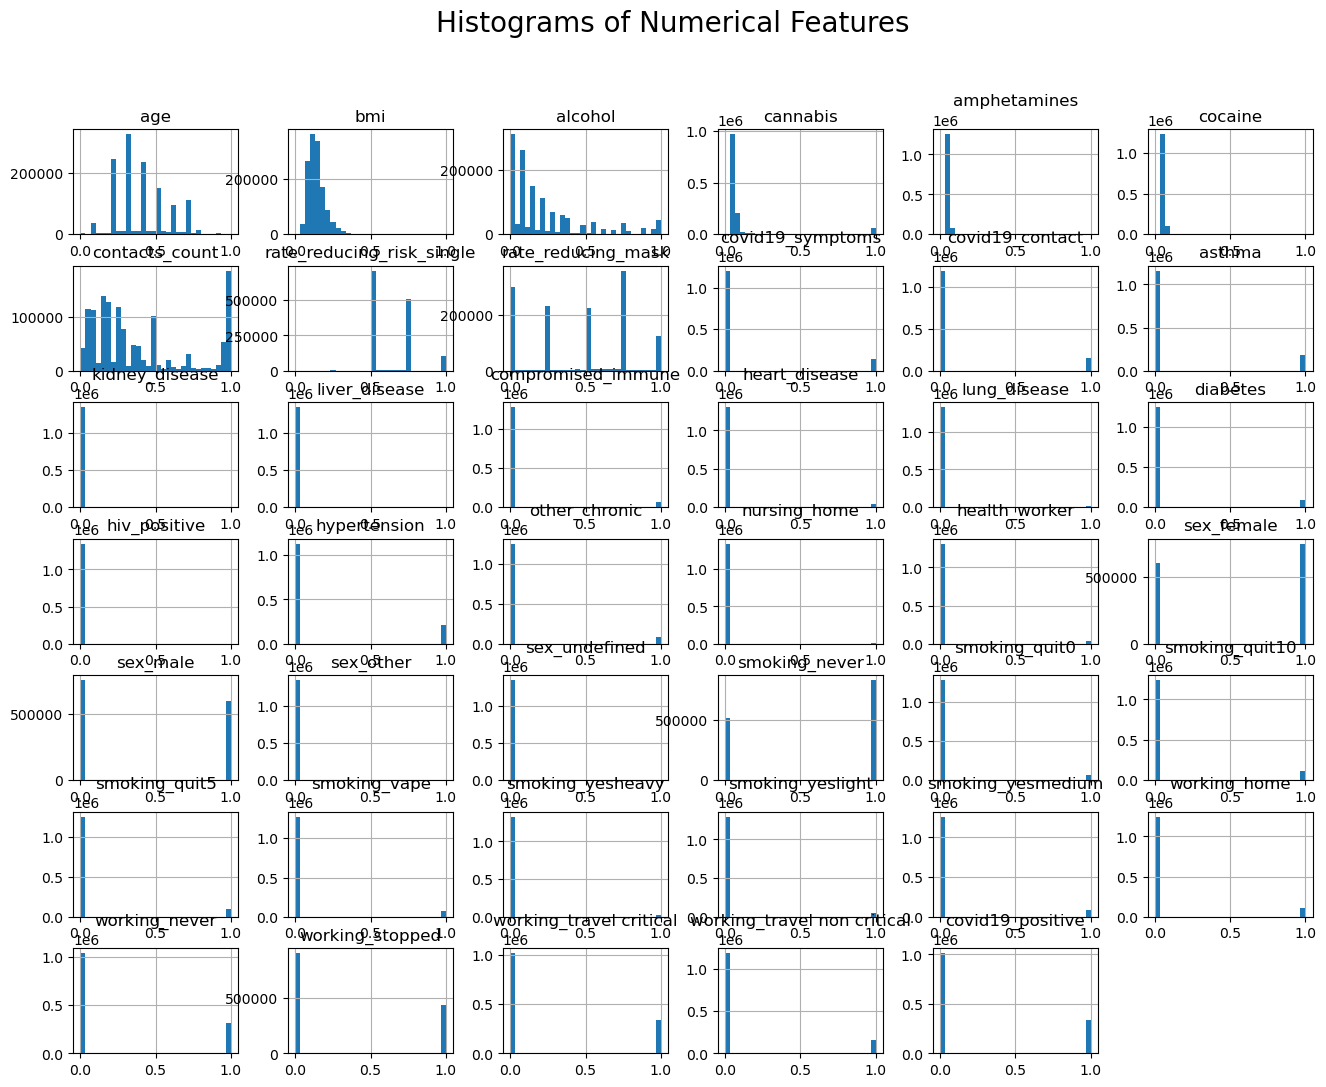

No categorical features for count plots.


/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


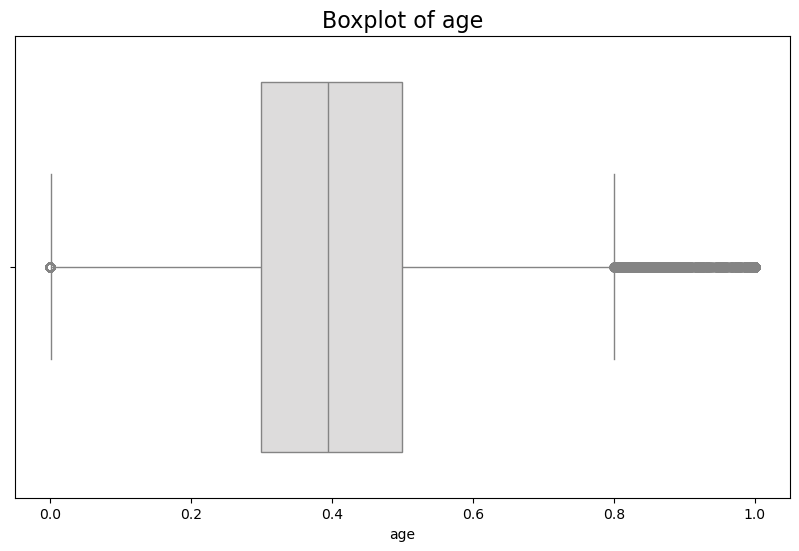

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


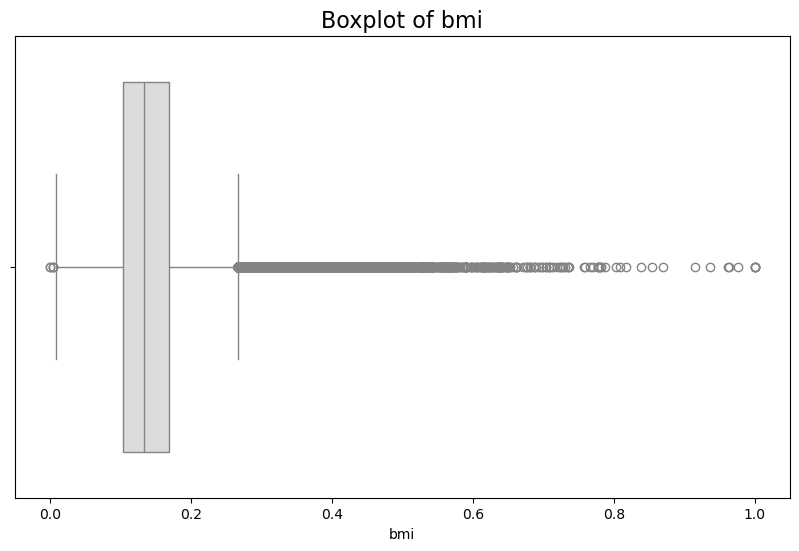

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


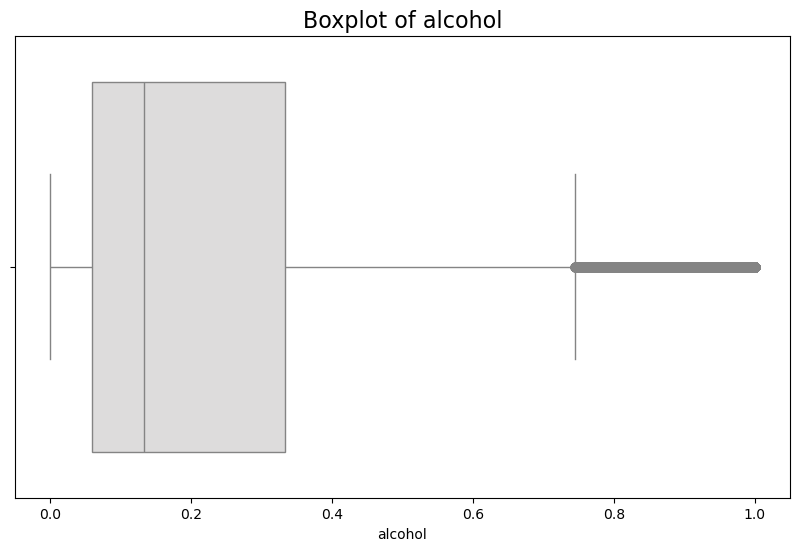

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


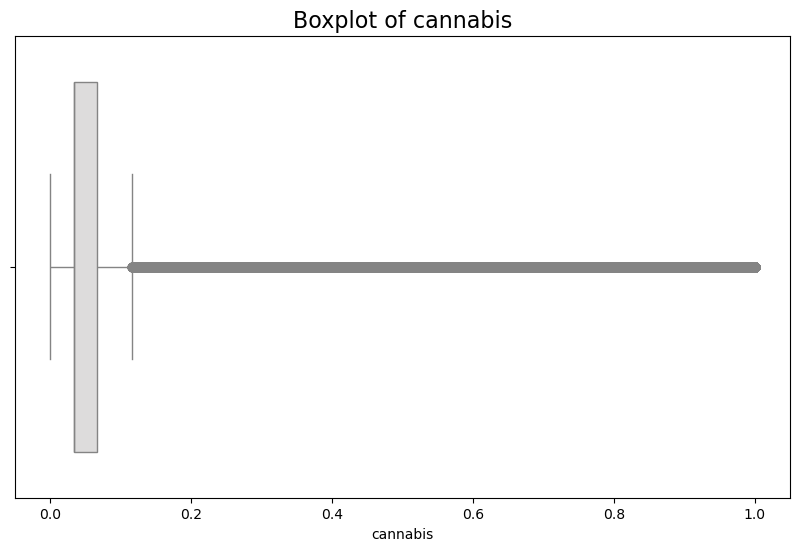

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


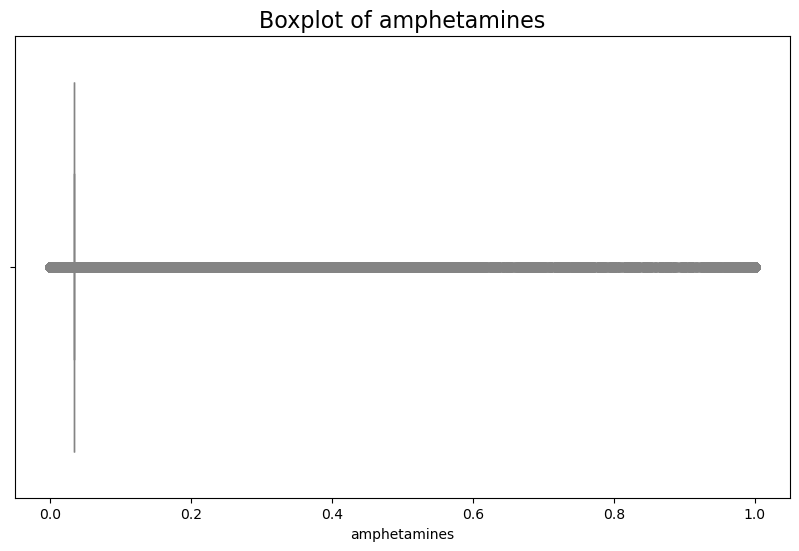

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


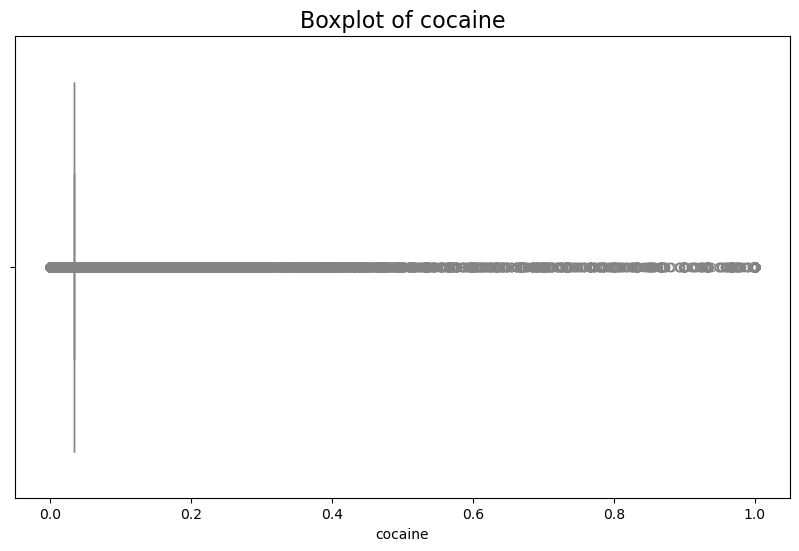

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


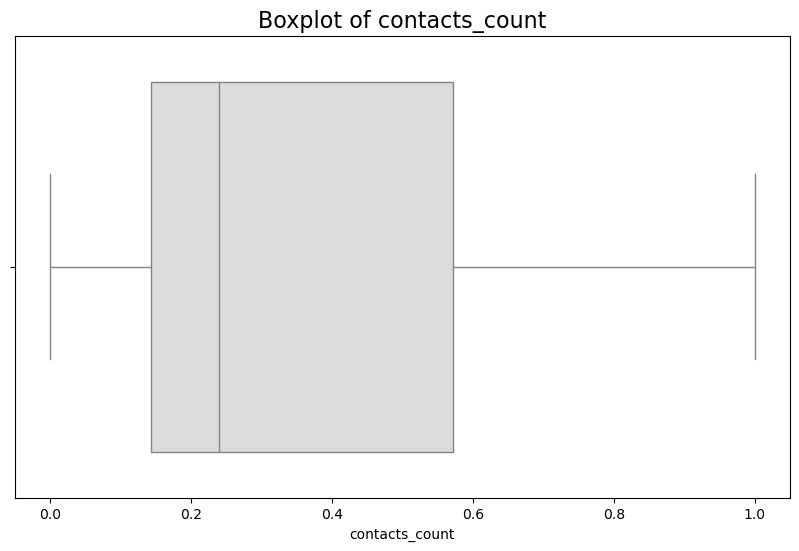

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


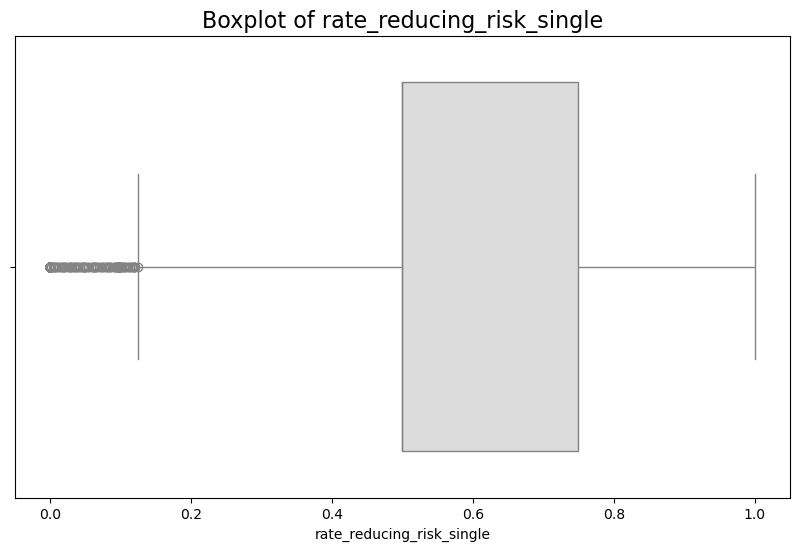

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


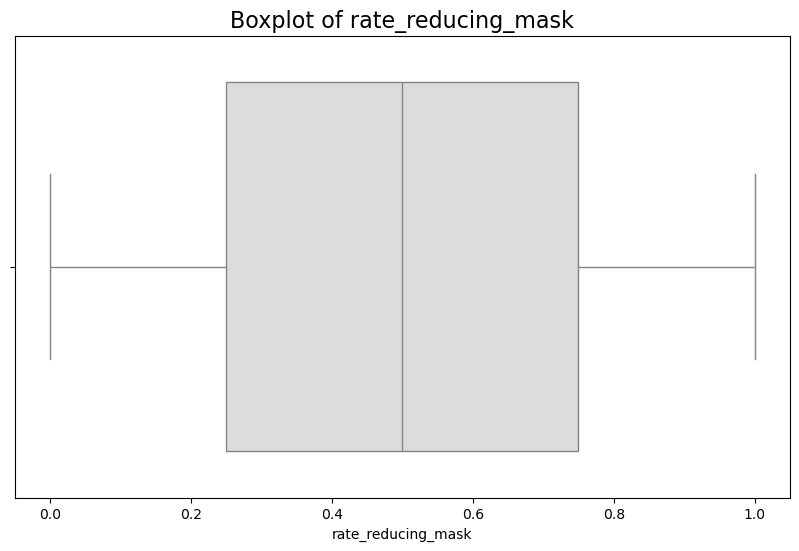

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


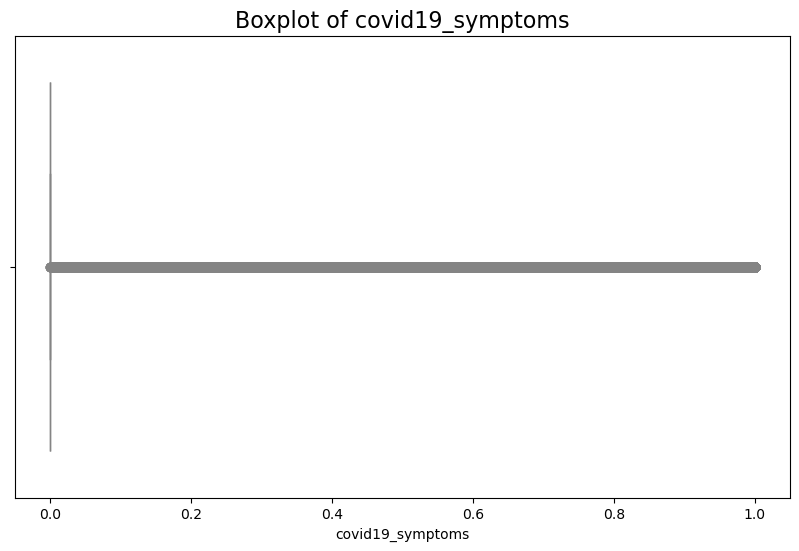

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


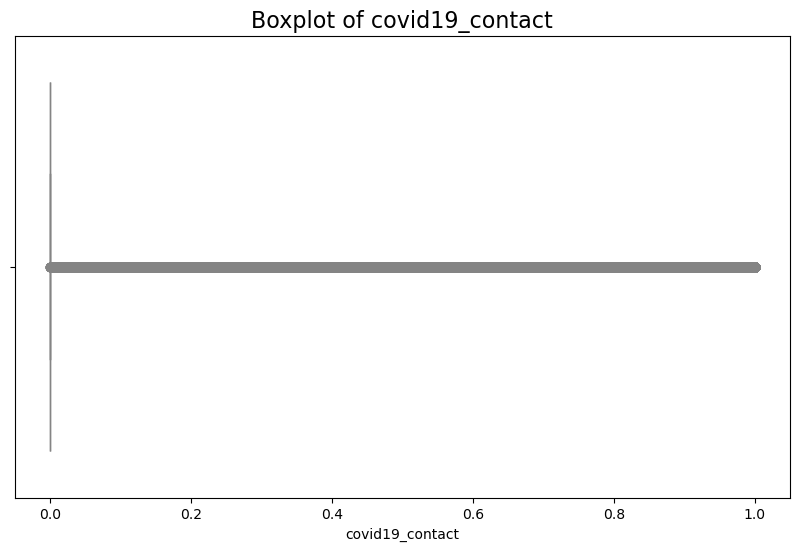

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


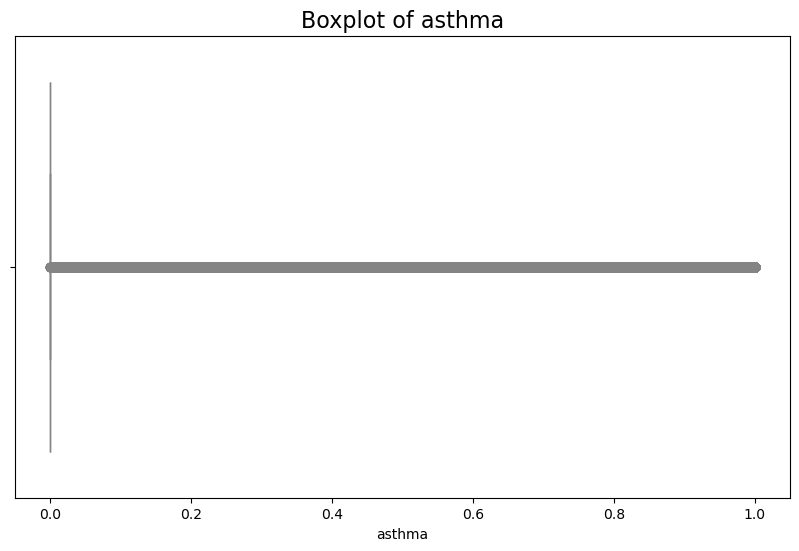

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


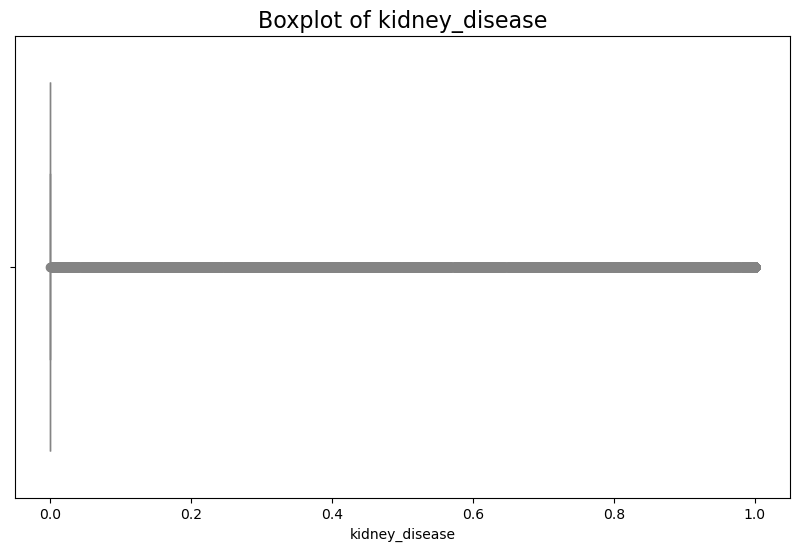

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


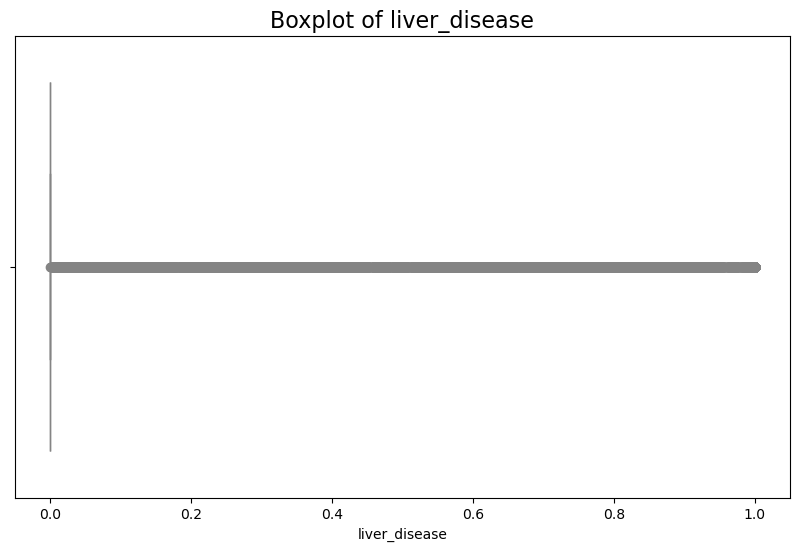

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


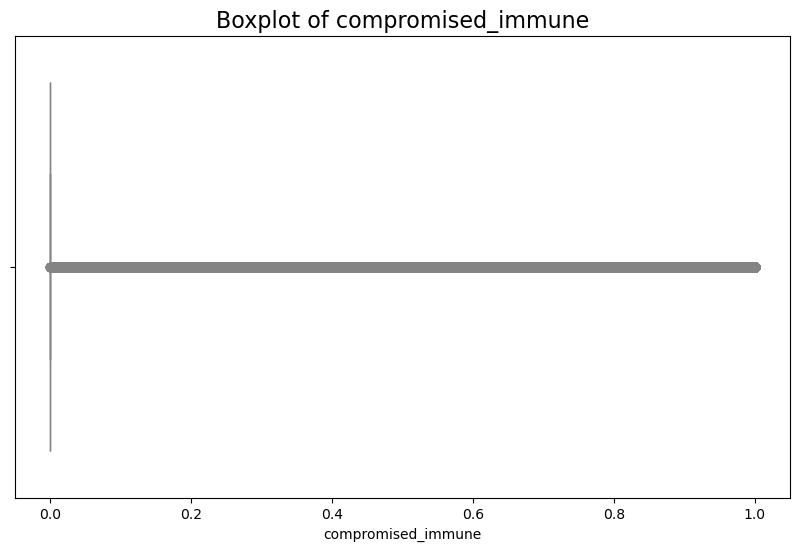

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


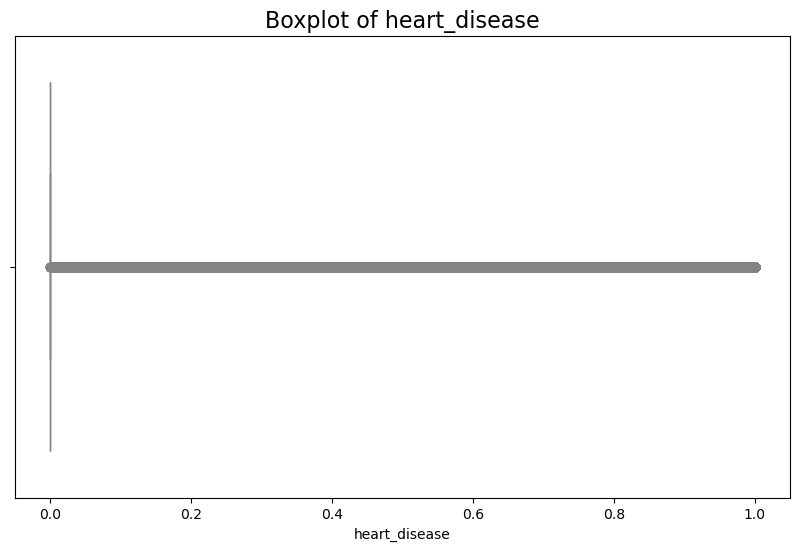

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


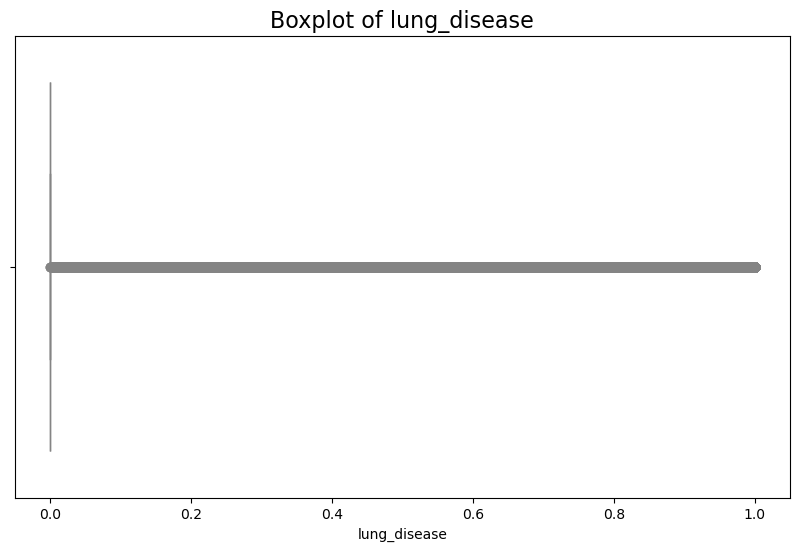

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


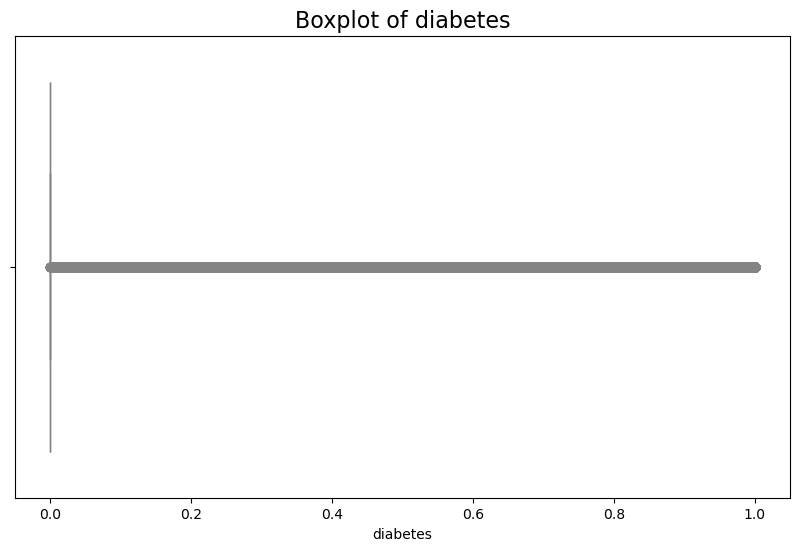

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


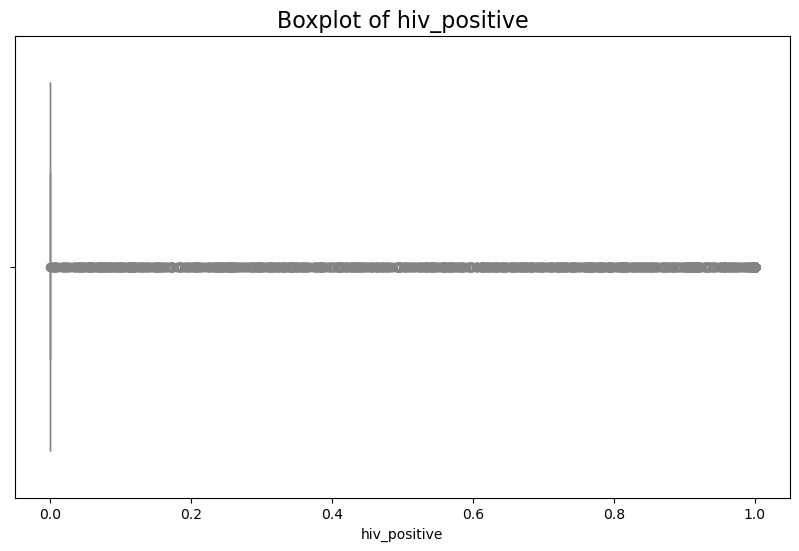

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


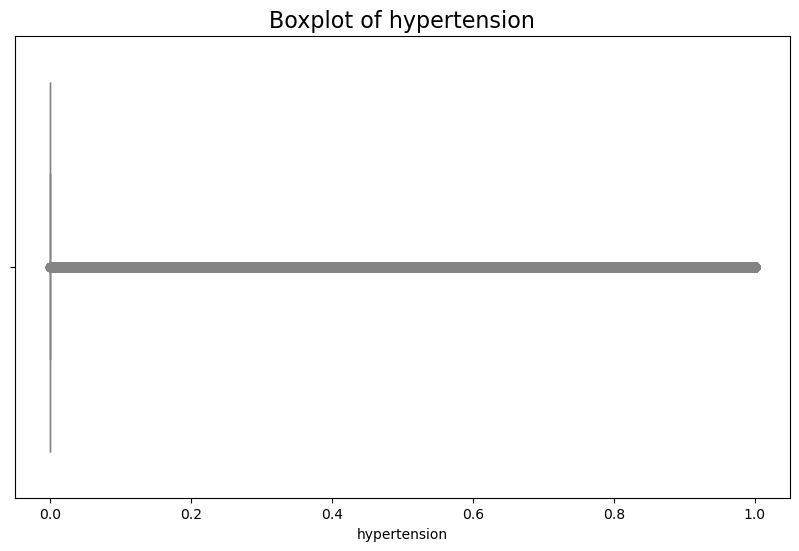

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


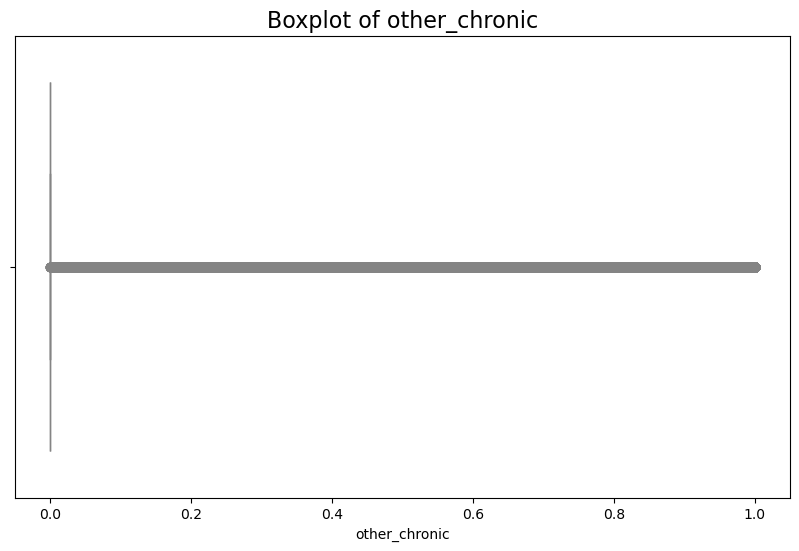

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


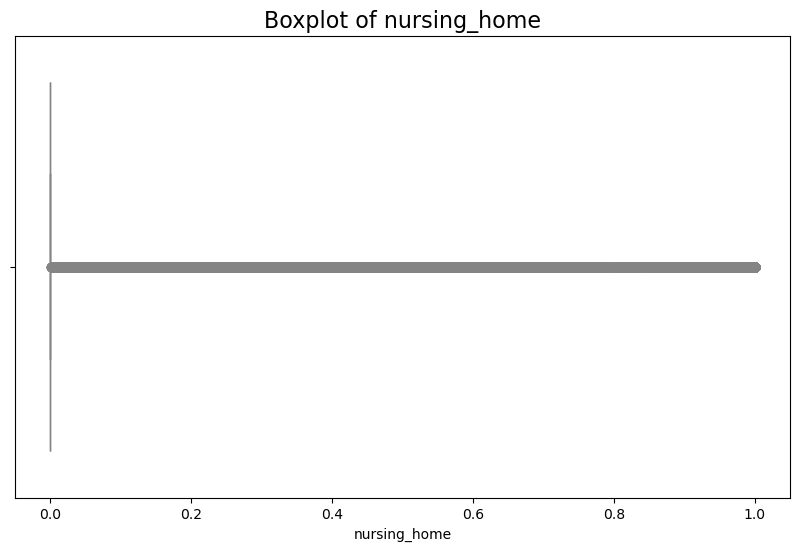

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


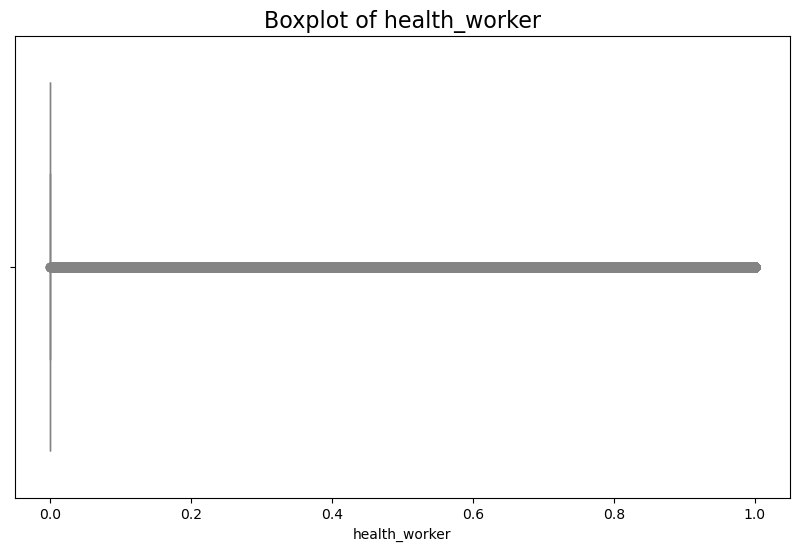

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


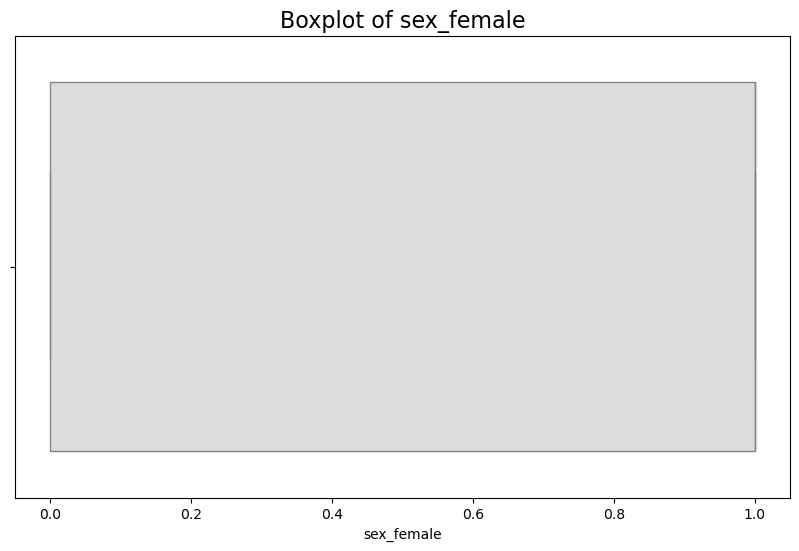

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


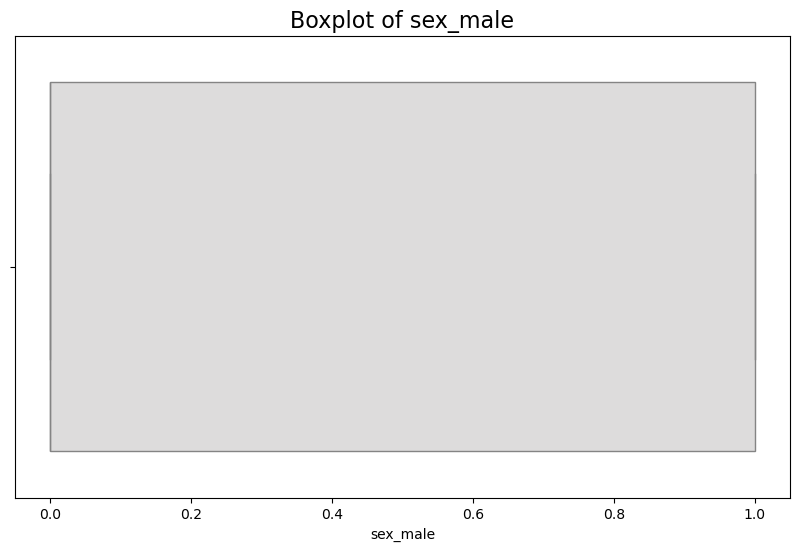

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


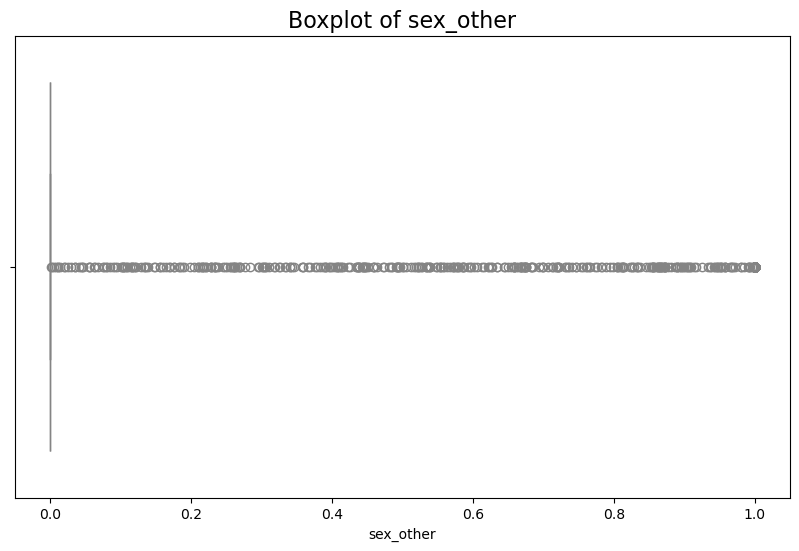

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


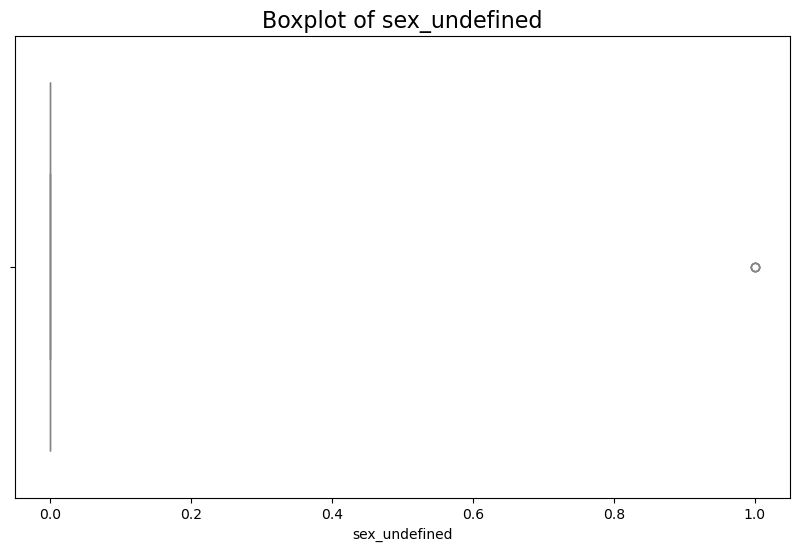

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


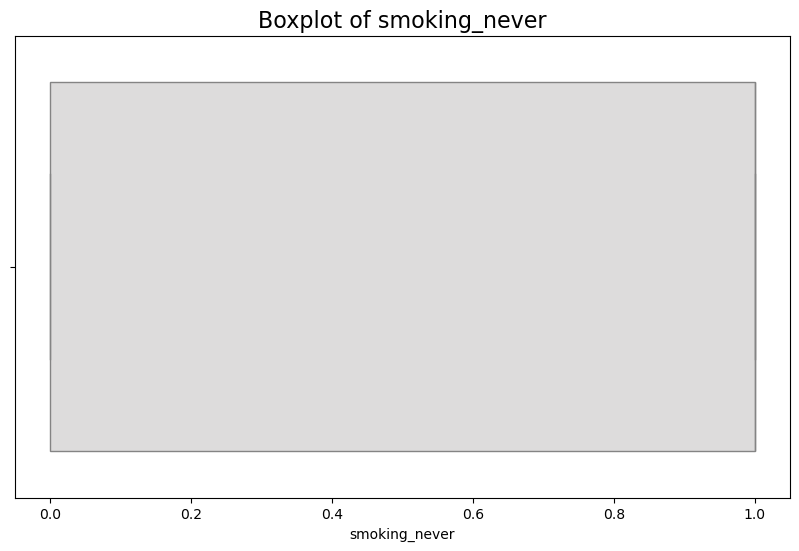

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


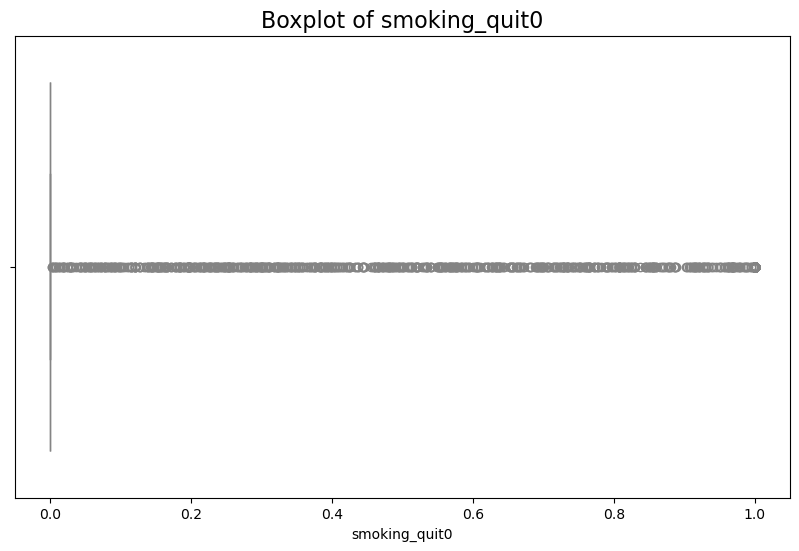

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


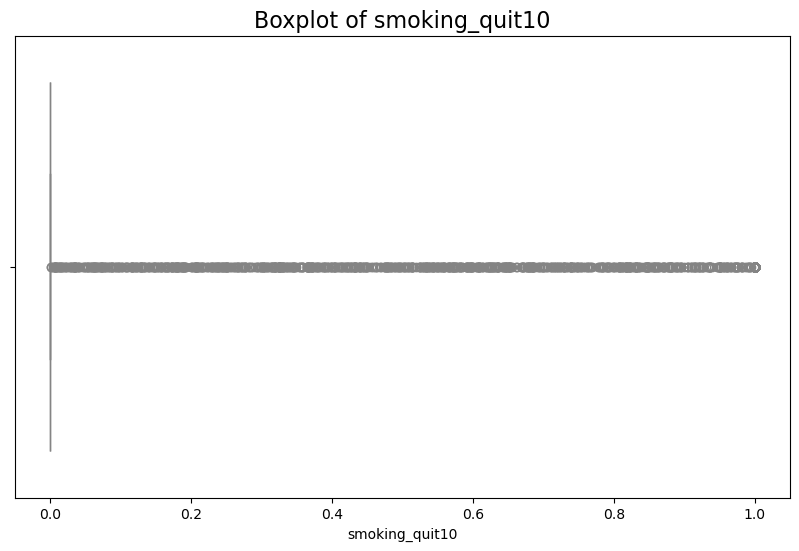

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


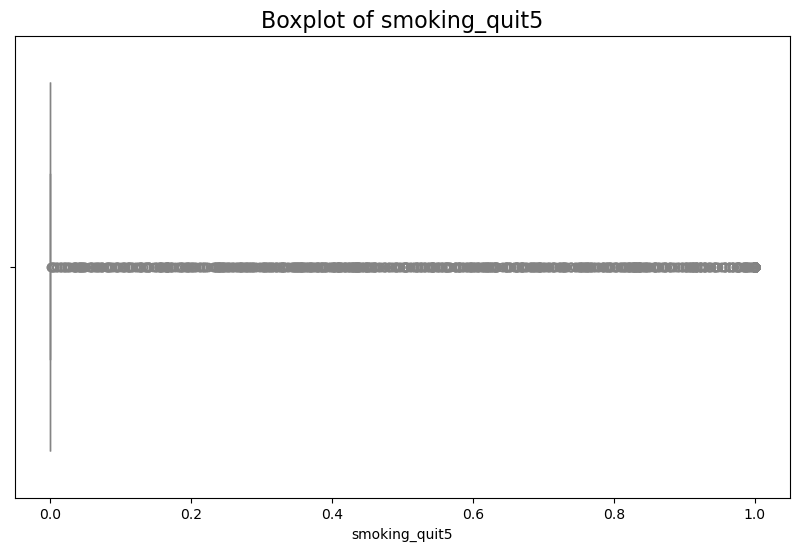

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


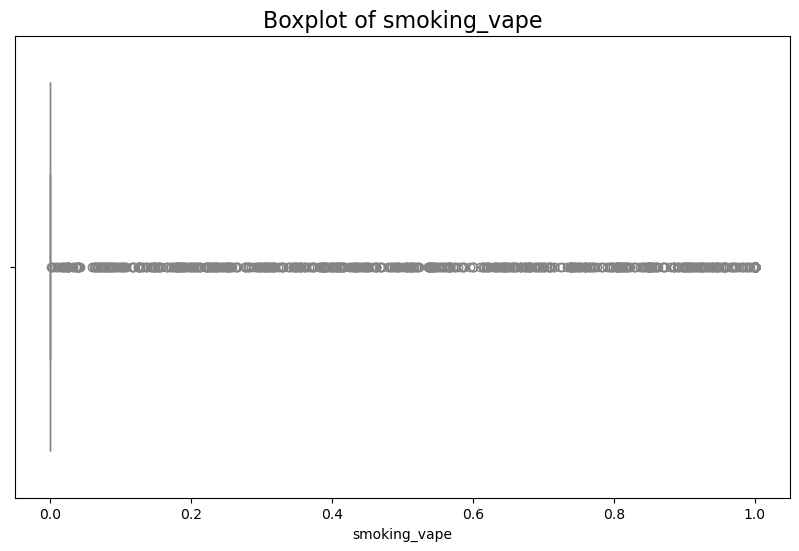

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


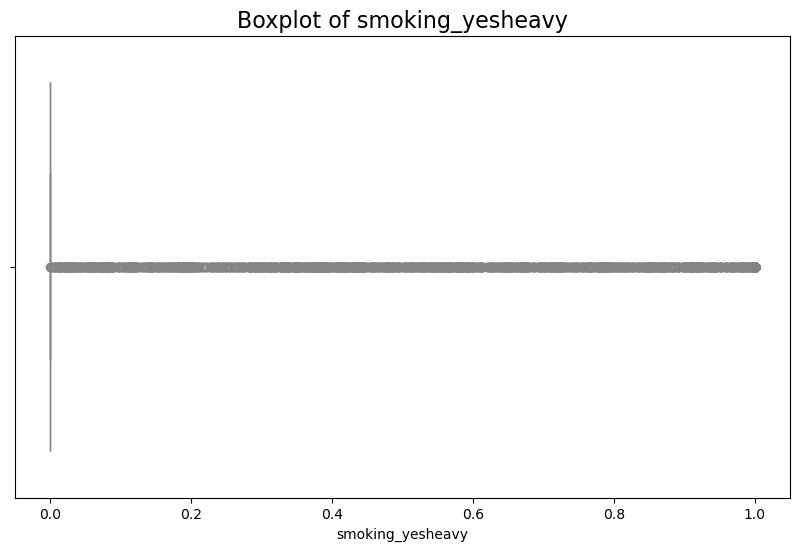

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


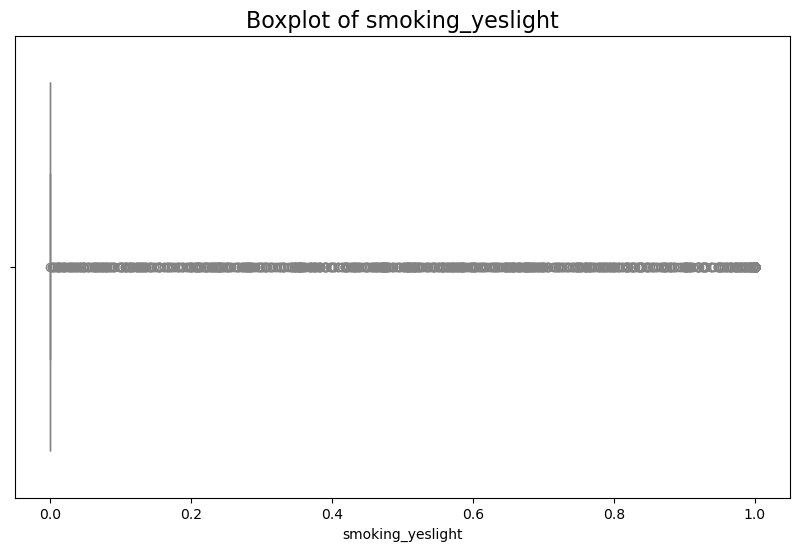

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


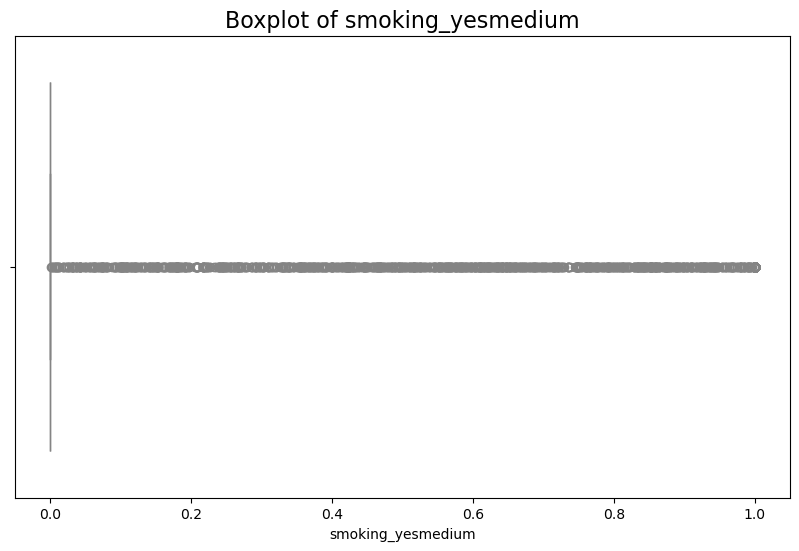

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


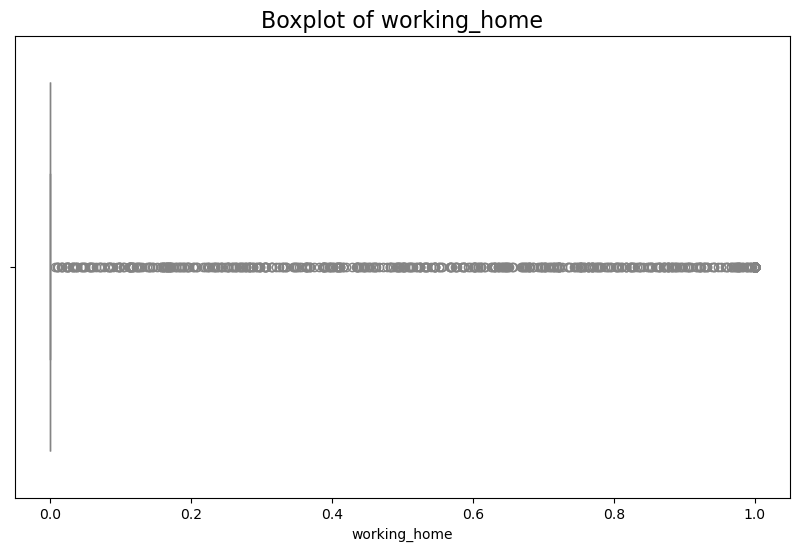

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


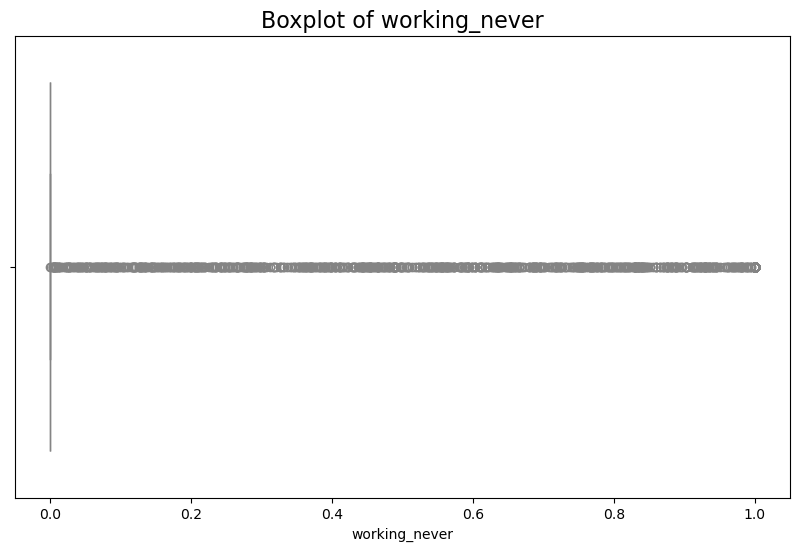

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


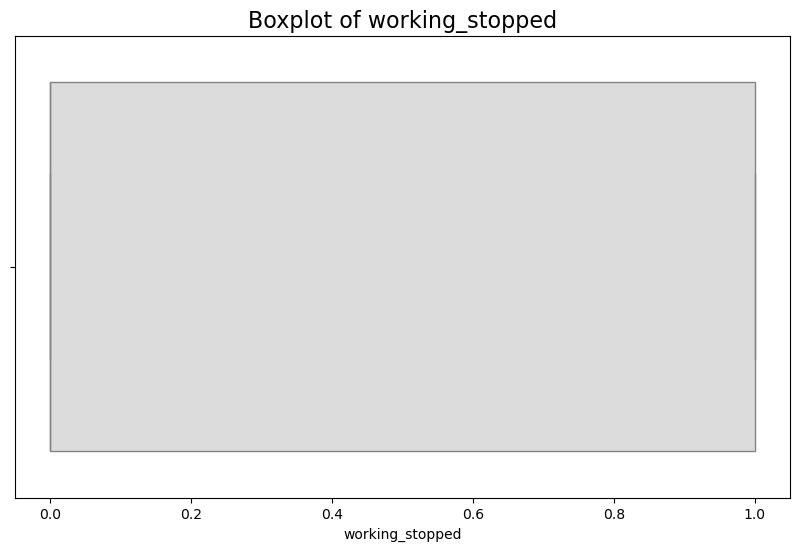

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


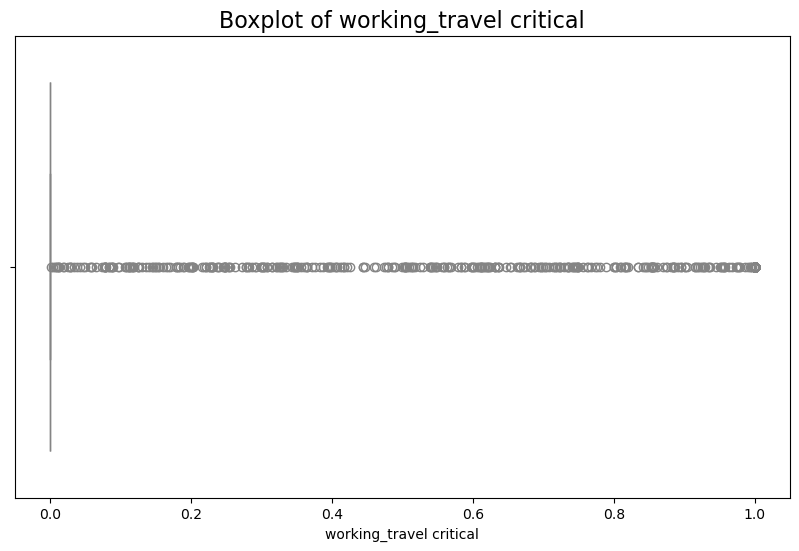

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


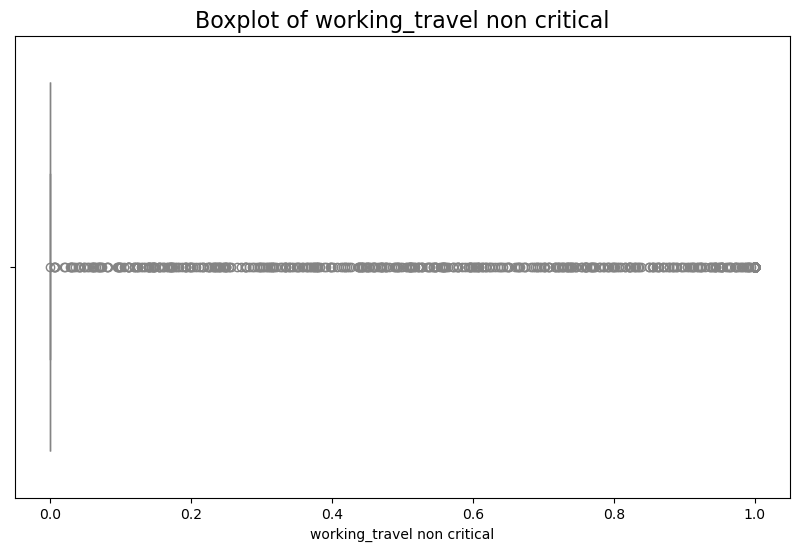

/tmp/ipykernel_338564/441311428.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette="coolwarm")


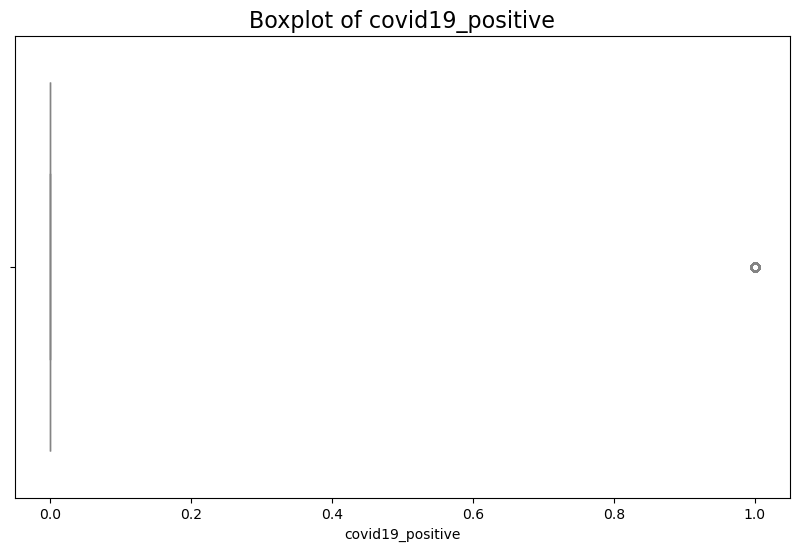

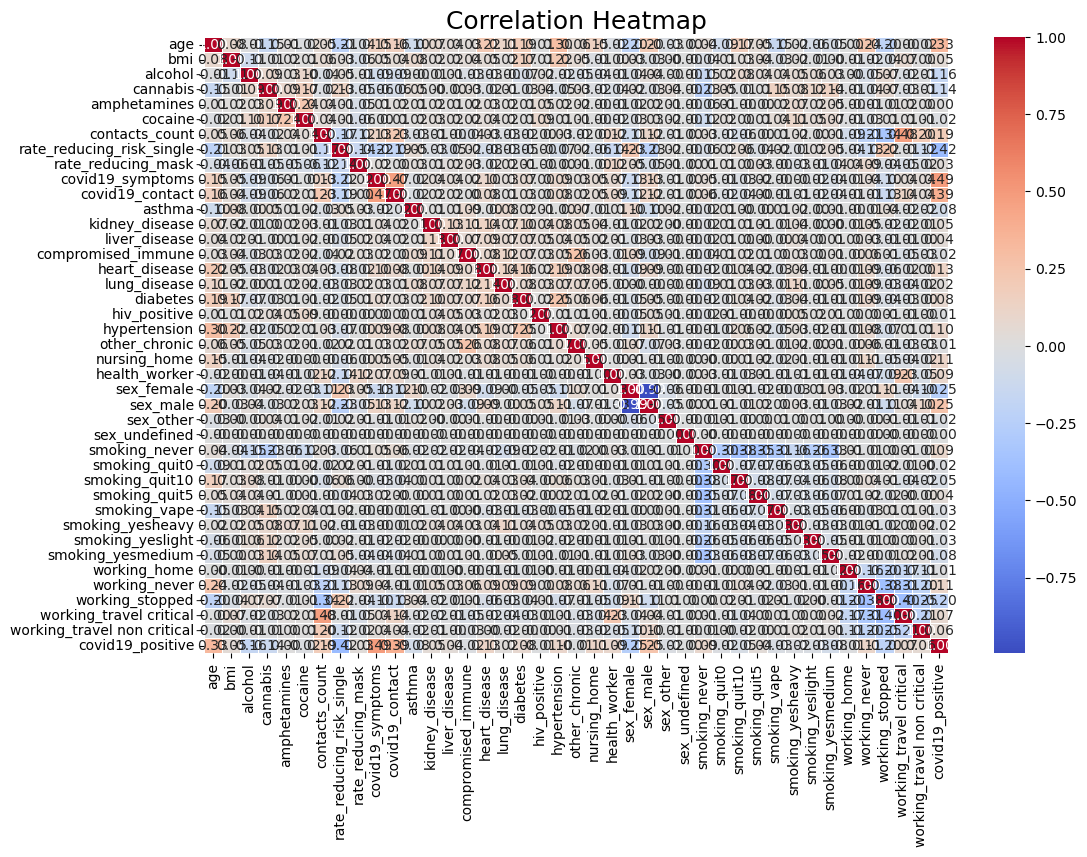

Too many features for a pairplot.
Target column not found in the DataFrame.


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (change the filename if needed)

# Reset the index to avoid duplicate index issues
df = df.reset_index(drop=True)

# 1. Basic Information
print("\n==== Basic Information ====")
df.info()

print("\n==== First 5 Rows ====")
print(df.head())

# 2. Summary Statistics
print("\n==== Summary Statistics (Numerical Features) ====")
print(df.describe())

# Check for categorical columns before describing them
cat_cols = df.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print("\n==== Summary Statistics (Categorical Features) ====")
    print(df.describe(include=['object']))
else:
    print("\nNo categorical features to describe.")

# 3. Checking for Missing Values
print("\n==== Missing Values per Column ====")
print(df.isnull().sum())

# 4. Checking Duplicates
print("\n==== Number of Duplicate Rows ====")
print(df.duplicated().sum())

# 5. Unique Values in Categorical Columns
if len(cat_cols) > 0:
    print("\n==== Unique Values in Each Categorical Column ====")
    for col in cat_cols:
        print(f"{col}: {df[col].nunique()} unique values")
else:
    print("\nNo categorical features to show unique values.")

# 6. Data Distribution Visualizations

# Histograms for numerical features with a larger figure size
print("\nDisplaying Histograms for Numerical Features...")
df.hist(figsize=(16, 12), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=20)
plt.show()

# Count plots for categorical features with a larger figure size
if len(cat_cols) > 0:
    for col in cat_cols:
        plt.figure(figsize=(10, 6))
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, order=order, palette="viridis")
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(f"Count Plot of {col}", fontsize=16)
        plt.show()
else:
    print("No categorical features for count plots.")

# 7. Outlier Detection using Boxplots for numerical features (bigger size)
for col in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col], palette="coolwarm")
    plt.title(f"Boxplot of {col}", fontsize=16)
    plt.show()

# 8. Correlation Heatmap with increased size
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=18)
plt.show()

# 9. Pairplot (only for small datasets to keep it fast) with increased size
if df.shape[1] <= 6:
    if len(cat_cols) > 0:
        sns.pairplot(df, hue=cat_cols[0], height=3)
    else:
        sns.pairplot(df, height=3)
    plt.show()
else:
    print("Too many features for a pairplot.")

# 10. Checking Class Imbalance for Target Variable with larger plot size
target_col = "target"  # Change this to your actual target column name if applicable
if target_col in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df[target_col], palette="Set2")
    plt.title("Class Distribution of Target Variable", fontsize=16)
    plt.show()
else:
    print("Target column not found in the DataFrame.")


In [ ]:
# Get the counts of each class in the 'target' column
class_counts = df['covid19_positive'].value_counts()
print("Counts of each class in 'target':")
print(class_counts)

# Get the percentage for each class
class_percentages = df['covid19_positive'].value_counts(normalize=True) * 100
print("\nPercentage of each class in 'target':")
print(class_percentages)


In [ ]:
# Count numerical features
num_features = df.select_dtypes(include=['number'])
print("Number of numerical features:", len(num_features.columns))

# Count categorical features
cat_features = df.select_dtypes(include=['object'])
print("Number of categorical features:", len(cat_features.columns))


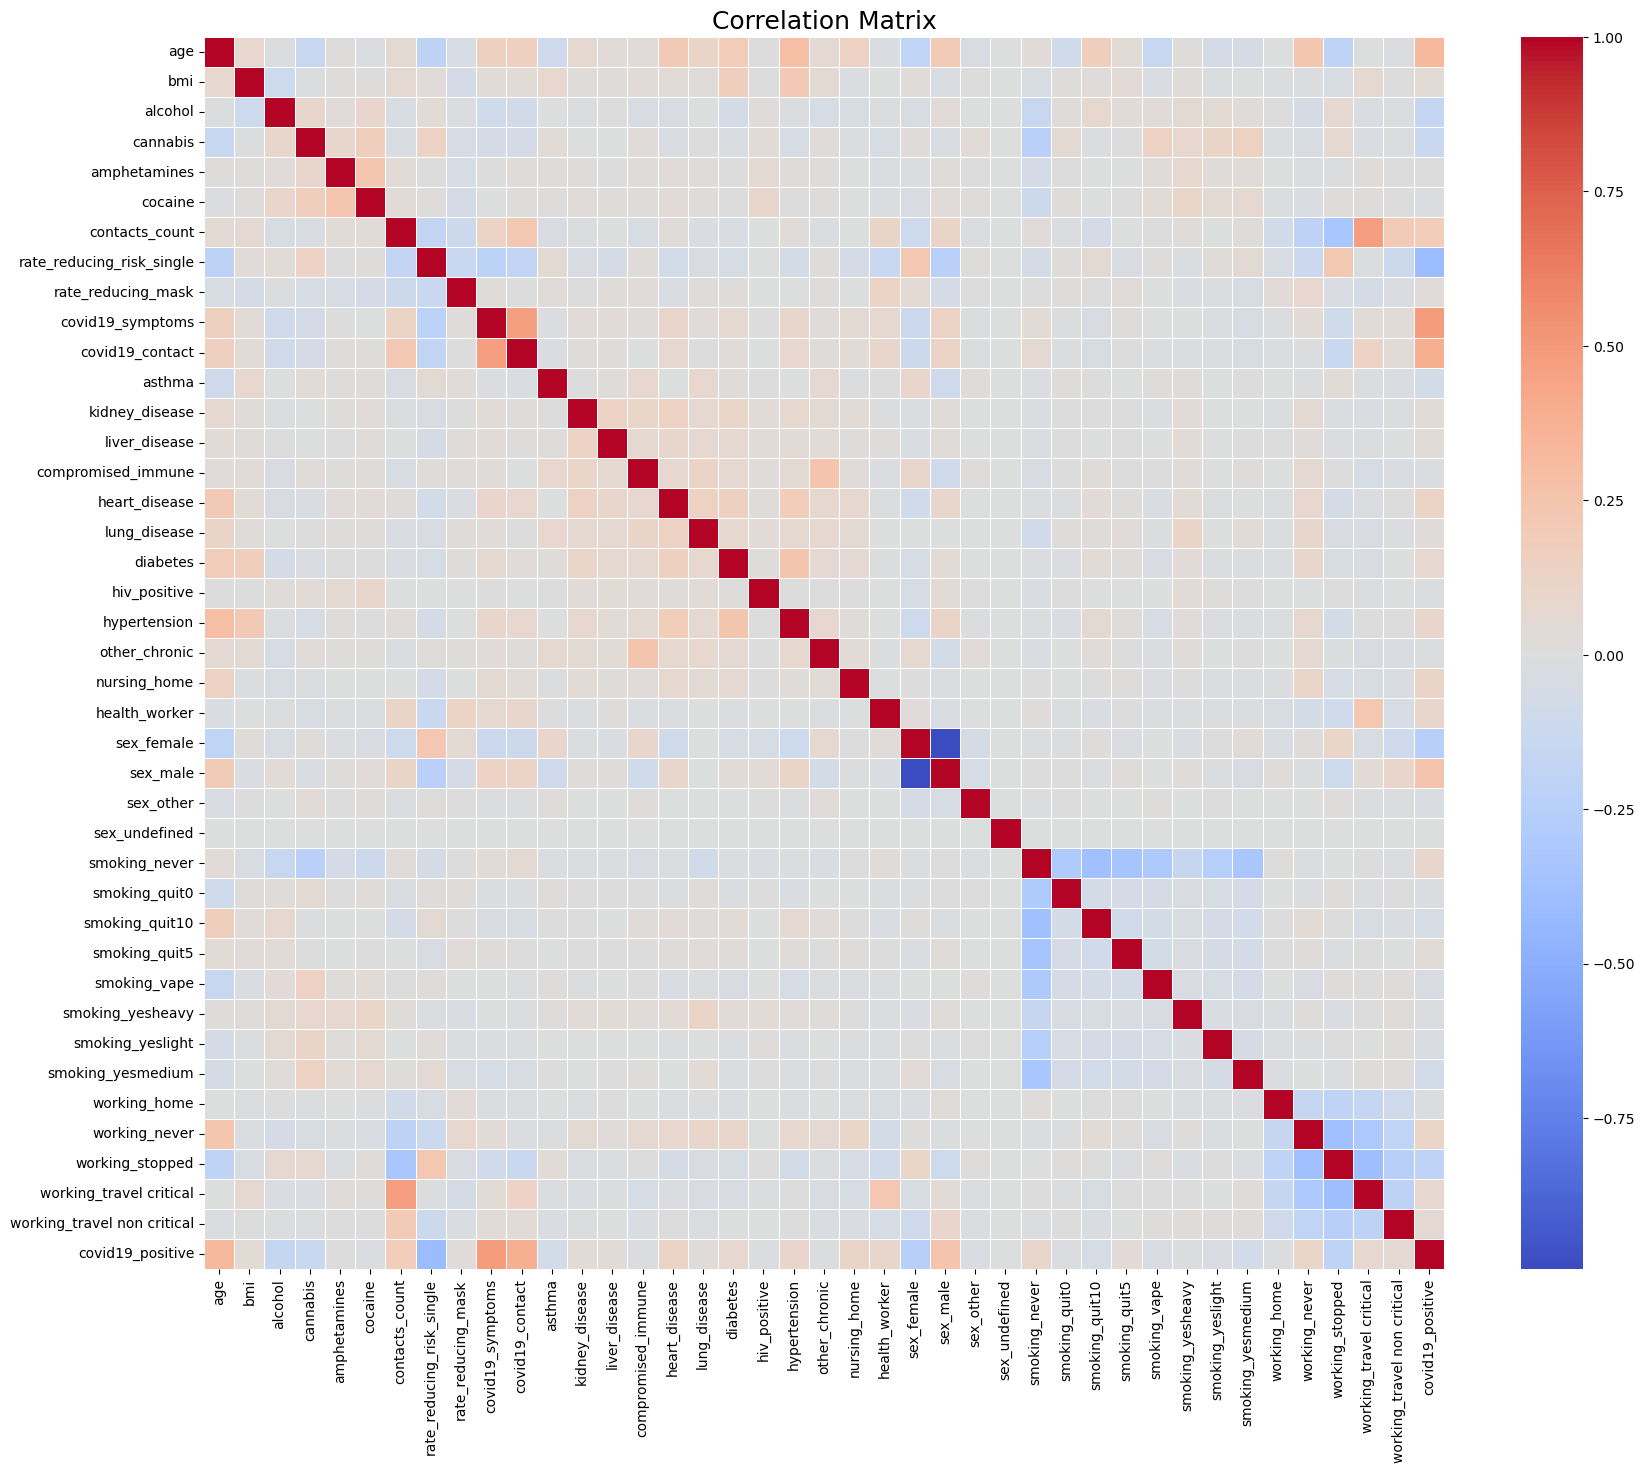

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already loaded your DataFrame 'df'
# For example:
# df = pd.read_csv("master_dataset.csv")

# Calculate the correlation matrix for numerical features
correlation_matrix = df.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=18)
plt.show()
